In [10]:
import torch
t = torch.tensor([[[1, 2],
                   [3, 4]],
                  [[5, 6],
                   [7, 8]]])
print(t.size())
print(t.view(t.size(0),-1).shape)
t.view(t.size(0),-1)

2
torch.Size([2, 4])


tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])

In [86]:
import numpy as np
src = [0,2,3,6,1,5]
src = np.array(src)
src.argsort().argsort()+1
src.tolist()

[0, 2, 3, 6, 1, 5]

In [ ]:
a = a[b]
a

In [7]:
from torch.utils.tensorboard import  SummaryWriter
logger = SummaryWriter("log/test")
logger.add_text("Best Acc", str(12), global_step=0)

In [1]:
import numpy as np
import pandas as pd
test_acc = pd.read_csv('./runs/cifar100_110_case2_1/test_acc.csv')
best_error = 100 - test_acc['Value'].max()
best_error

26.37000274658203

In [4]:
from resnet_2 import resnet110
import netron
import torch
from torch.utils import tensorboard
model = resnet110(case=4).cuda()
ts = tensorboard.SummaryWriter(log_dir="./log/case4")
ts.add_graph(model ,torch.randn(128, 3, 32, 32).cuda())
'''torch.save(model.state_dict(), "test.pth")
x = torch.randn(128, 3, 36, 36).cuda()  # 随机生成一个输入
torch.onnx.export(model,x , 'test.pth')  # 将 pytorch 模型以 onnx 格式导出并保存
netron.start('test.pth')  # 输出网络结构

modelData = "./demo.pth"  # 定义模型数据保存的路径
netron.start('test.pth')  # 输出网络结构'''

'torch.save(model.state_dict(), "test.pth")\nx = torch.randn(128, 3, 36, 36).cuda()  # 随机生成一个输入\ntorch.onnx.export(model,x , \'test.pth\')  # 将 pytorch 模型以 onnx 格式导出并保存\nnetron.start(\'test.pth\')  # 输出网络结构\n\nmodelData = "./demo.pth"  # 定义模型数据保存的路径\nnetron.start(\'test.pth\')  # 输出网络结构'

In [1]:
from resnet_2 import resnet164
import torch
from torch.utils import tensorboard
model = resnet164(case=0).cuda()
ts = tensorboard.SummaryWriter(log_dir="./log/resnet164/model0")

ts.add_graph(model ,torch.randn(64, 3, 32, 32).cuda())


In [2]:
case=1
if case not in {0, 1, 2, 3, 4}:
    raise ValueError('Case only support {0,1,2,3,4}')

ValueError: Case only support {0,1,2,3,4}

In [73]:
import numpy as np

i = np.identity(5)
i1 = np.array([[1,1,1,1,1]]).T
i_ = 1/5 * (i - 1/5 * (i1@i1.T))
x = np.random.random([3,5])
dp = np.random.random([3,3])
p = x@i_@x.T
p

array([[ 0.09069127, -0.03566648,  0.0599517 ],
       [-0.03566648,  0.06645802, -0.00721617],
       [ 0.0599517 , -0.00721617,  0.08830344]])

In [200]:
from torch.autograd import Function
class MultiplyAdd(Function):

    @staticmethod
    def forward(ctx, w, x, b):
        ctx.save_for_backward(x, )#存储用来反向传播的参数
        output = w*x +b
        return output

    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors #deprecated,现在使用saved_tensors
        grad_w = grad_output * x
        grad_b = grad_output * 1
        return grad_w, None, grad_b

w = torch.tensor([[1.,2],[3,4]], requires_grad=True)
x = torch.rand(2, 2)
b = torch.tensor([[4.,3],[2,1]], requires_grad=True)
w,x,b

(tensor([[1., 2.],
         [3., 4.]], requires_grad=True),
 tensor([[0.6892, 0.2267],
         [0.0124, 0.5823]]),
 tensor([[4., 3.],
         [2., 1.]], requires_grad=True))

In [201]:
ag_func = MultiplyAdd()
out = ag_func.apply(w, x, b)
out.backward(torch.ones(2,2), retain_graph=True)
w.grad, b.grad

(tensor([[0.6892, 0.2267],
         [0.0124, 0.5823]]),
 tensor([[1., 1.],
         [1., 1.]]))

In [185]:
print(out.grad_fn)
print(out.grad_fn.next_functions)
# print(out.grad_fn.saved_tensors)
print(out.grad_fn.next_functions[0][0].variable)
print(out.grad_fn.next_functions[2][0].variable)

((<AccumulateGrad object at 0x0000014F2AF82040>, 0), (None, 0), (<AccumulateGrad object at 0x0000014F2A53F250>, 0))
tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
tensor([[4., 3.],
        [2., 1.]], requires_grad=True)


In [202]:
from graphviz import Digraph

node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
seen = set()

def size_to_str(size):
    return '(' + (', ').join(['%d' % v for v in size]) + ')'

def add_nodes(var):

    if var not in seen:
        if torch.is_tensor(var):
            # note: this used to show .saved_tensors in pytorch0.2, but stopped
            # working as it was moved to ATen and Variable-Tensor merged
            dot.node(str(id(var)), size_to_str(var.size()), fillcolor='yellow')
        elif hasattr(var, 'variable'):
            u = var.variable
            node_name = size_to_str(u.size())
            dot.node(str(id(var)), node_name, fillcolor='lightblue')
        else:
            dot.node(str(id(var)), str(type(var).__name__))

            seen.add(var)
        if hasattr(var, 'next_functions'):
            for u in var.next_functions:
                if u[0] is not None:
                    dot.edge(str(id(u[0])), str(id(var)))
                    add_nodes(u[0])
        if hasattr(var, 'saved_tensors'):
            for t in var.saved_tensors:
                dot.edge(str(id(t)), str(id(var)))
                add_nodes(t)
dot.node('Output', 'out\n'+size_to_str(out.size()))
dot.edge( str(id(out.grad_fn)),'Output')
add_nodes(out.grad_fn)
dot.render(('graph'), view=False)

'graph.pdf'

In [3]:
from resnet_2 import resnet164

import torchsummary

model = resnet164(case=0)
model.cuda()
torchsummary.summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
            Conv2d-2           [-1, 64, 32, 32]           1,024
       BatchNorm2d-3           [-1, 64, 32, 32]             128
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]           4,096
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]           1,024
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
       Bottleneck-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [30]:
import numpy as np
a = np.eye(4000)
a

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [129]:
mean = np.zeros([2000]) #均值向量
matrix = np.eye(2000)
# using np.multinomial() method
gfg = np.random.multivariate_normal(mean, matrix, 4000) #5生成5个样本点
_,v,_=np.linalg.svd(matrix)
v

KeyboardInterrupt: 

In [127]:
cov = np.cov(gfg.T)
_,v,_=np.linalg.svd(cov)
v=v[np.argwhere(v>1e-9)]
len(v)

2000

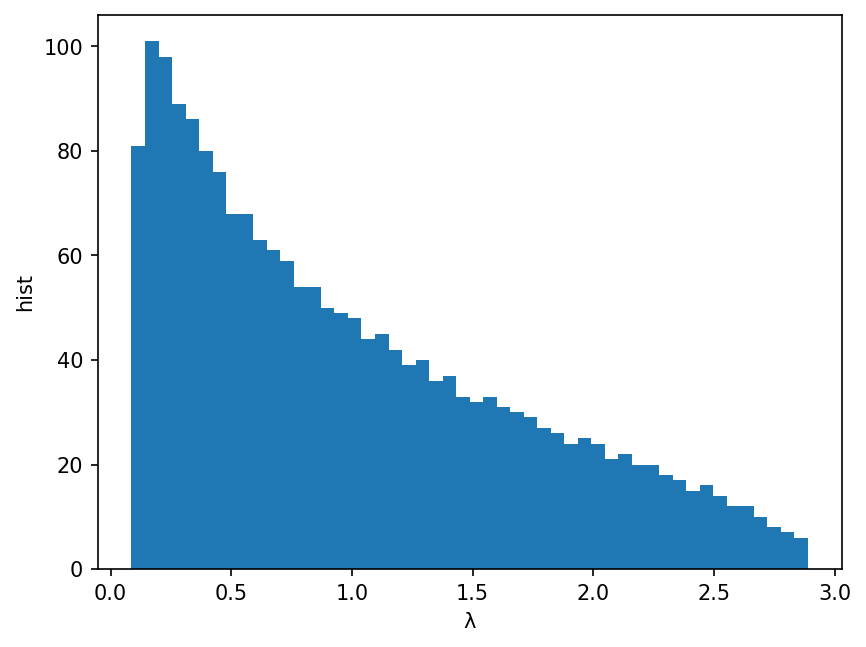

In [140]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
n,bins,_=plt.hist(v,bins=50)
plt.tight_layout()
plt.xlabel("λ")
plt.ylabel("hist")
plt.savefig('特征值.png')